<div style='padding:15px;color:#030aa7;font-size:240%;text-align: center;font-style: italic;font-weight: bold;font-family: Georgia, serif'>BloodMNIST<br> Standardized Biomedical Images</div>
<div style='text-align: center'>
    <img src="https://raw.githubusercontent.com/rbizoi/DeepLearning/refs/heads/main/images/bloodMNIST.png" width="512">
</div>      


# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Initialisation du document</div></b>

In [1]:
import os
# import json
# @param ["tensorflow", "jax", "torch"]
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'  
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
# os.environ['TF_XLA_FLAGS']='--tf_xla_auto_jit=1,--tf_xla_always_defer_compilation=true'
# os.environ['XLA_FLAGS']='--xla_backend_optimization_level=0,--xla_gpu_autotune_level=4,--xla_gpu_disable_ptxas_optimizations=true,--xla_gpu_use_cudnn_batchnorm_level=2'
# os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL']='5'

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Import libriries </div></b>

In [2]:
import numpy as np, pandas as pd, seaborn as sns, warnings, os, sys, pickle
from matplotlib import pyplot as plt
from datetime import datetime as dt

import matplotlib.font_manager as fm
from matplotlib.lines import Line2D

warnings.filterwarnings(action="ignore")

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
    
sns.set(font_scale=2)

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist,fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D

tf.get_logger().setLevel('ERROR')# Suppress TensorFlow logging (2)

In [4]:
print("Tensorflow\t : %s\tCUDA %s\tGPU %s\tXLA %s\nKeras\t\t : %s\nPandas\t\t : %s\nNumPy\t\t : %s"%
      (tf.__version__, 
       tf.test.is_built_with_cuda(), 
       tf.test.is_built_with_gpu_support(), 
       tf.test.is_built_with_xla(), 
       tf.keras.__version__, 
       pd.__version__, 
       np.__version__))

Tensorflow	 : 2.17.0	CUDA True	GPU True	XLA True
Keras		 : 3.6.0
Pandas		 : 2.2.2
NumPy		 : 1.26.4


# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Initialisation des GPUs presents</div></b>

In [ ]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) >  0 :
    for i, gpu in enumerate(physical_devices):
        tf.config.experimental.set_memory_growth(physical_devices[i], True)

    strategy = tf.distribute.experimental.CentralStorageStrategy()
    print('Le système est initialisé avec {0:d} GPUs'.format(strategy.num_replicas_in_sync))

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Outils du document</div></b>

In [6]:
palette = [
            "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", "#d1e5f0", "#fddbc7",
            "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#f5054f", "#a0450e",
            "#0339f8", "#f4320c", "#fec615", "#017a79", "#85a3b2", "#fe2f4a", "#a00498", "#b04e0f",
            "#0165fc", "#ff724c", "#fddc5c", "#11875d", "#89a0b0", "#fe828c", "#cb00f5", "#b75203",
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#ffb7ce", "#c071fe", "#ca6b02",
            "#92c5de", "#f4a582", "#fef69e", "#18d17b", "#c5c9c7", "#ffcfdc", "#caa0ff", "#cb7723",
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#d8863b",
            "#030764", "#be0119", "#dbb40c", "#005249", "#3c4142", "#cb0162", "#5d1451", "#653700",
            "#040348", "#67001f", "#b27a01", "#002d04", "#000000", "#a0025c", "#490648", "#3c0008"
          ]

In [7]:
nom_projet                = "03-La création du modèle l'entrainement et l'exécution-bloodMNIST-Sparse"
repertoireProjet          = os.getcwd()
repertoireEnregistrement  = repertoireProjet +'/'+nom_projet+ '/repertoire.images'
repertoireSauvegardes     = repertoireProjet +'/'+nom_projet+ '/repertoire.sauvegardes'

def controleExistenceRepertoire(directory, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(directory)
    if path_exists:
        if not os.path.isdir(directory):
            raise Exception("Trouvé le nom "+directory+" mais c'est un fichier, pas un répertoire")
            return False
        return True
    if create_if_needed:
        os.makedirs(directory)
        
controleExistenceRepertoire(repertoireEnregistrement)
controleExistenceRepertoire(repertoireSauvegardes)

def sauvegarderImage( fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    plt.savefig(os.path.join(repertoireEnregistrement,
                             fichier+f"--{dt.now().strftime('%Y_%m_%d_%H.%M.%S')}.png"), 
                             dpi=600, 
                             bbox_inches='tight')


    
def sauvegarderModelPoids(model, fichierPoids, repertoireSauvegardes=repertoireSauvegardes):
    """Enregistrez les poids du modèle Keras."""
    if fichierPoids != None:
        controleExistenceRepertoire(repertoireSauvegardes)
        nomFichier = os.path.join(repertoireSauvegardes, '{}.keras'.format(fichierPoids))
        model.save_weights(nomFichier)

def sauvegarderModel(model, fichier, repertoireSauvegardes=repertoireSauvegardes):
    """Enregistrez le modèle Keras."""
    if fichier != None:
        controleExistenceRepertoire(repertoireSauvegardes)
        nomFichier = os.path.join(repertoireSauvegardes, '{}.keras'.format(fichier))
        model.save(nomFichier)

def lectureModelPoids(model, fichier, repertoireSauvegardes=repertoireSauvegardes):
    """Si le fichier existe, il est chargé et retourne True, sinon retourne False."""
    nomFichier = os.path.join(repertoireSauvegardes, '{}.keras'.format(fichier))
    if os.path.exists(nomFichier):
        if os.path.isfile(nomFichier):
            model.load_weights(nomFichier)
            return True
    return False

def sauvegardeHistorique(model,
                         repertoireSauvegardes,
                         nomSauvegarde='one_hidden_layer_history_batch_size_1'):

    history = pd.DataFrame( model.history)
    history.reset_index(inplace=True)
    history.rename(columns={'index':'epoch'},inplace=True)
    history.to_parquet(os.path.join(repertoireSauvegardes,f'{nomSauvegarde}.gzip'),compression='gzip', engine='pyarrow') 
    return history

def afficheHistoriqueEntrainement(history, palette):
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(48,16));
    markersize = 8
    linewidth=2
    
    graph = sns.lineplot(x='epoch', 
                         y='accuracy',  
                         data=history,
                         ax=ax[0],      
                         label='accuracy',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[0],
                         );
    graph = sns.lineplot(x='epoch', 
                         y='val_accuracy',  
                         data=history,
                         ax=ax[0],      
                         label='val_accuracy',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[1],
                         );
    
    graph = sns.lineplot(x='epoch', 
                         y='loss',  
                         data=history,
                         ax=ax[1],      
                         label='loss',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[0],
                         );
    graph = sns.lineplot(x='epoch', 
                         y='val_loss',  
                         data=history,
                         ax=ax[1],      
                         label='val_loss',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[1],
                         );
    sauvegarderImage('afficheHistoriqueEntrainement')
    

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Lecture des données</div></b>

In [8]:
batch_size = 32
imagesize = [28,28,3]
number_of_pixels = imagesize[0]*imagesize[1]*imagesize[2]
number_of_classes = 8

In [9]:
! ls ../donnees/MedMNIST/bloodmnist.npz

../donnees/MedMNIST/bloodmnist.npz


In [10]:
dictLabels = { 0:"basophil",
               1:"eosinophil",
               2:"erythroblast",
               3:"immature",# granulocytes(myelocytes, metamyelocytes and promyelocytes)",
               4:"lymphocyte",
               5:"monocyte",
               6:"neutrophil",
               7:"platelet"}

In [11]:
donnees = np.load("../donnees/MedMNIST/bloodmnist.npz")

In [12]:
apprentissage = np.reshape(donnees["train_images"],(donnees["train_images"].shape[0],
                                    donnees["train_images"].shape[1]*donnees["train_images"].shape[2]*donnees["train_images"].shape[3])).astype('float64')

validation = np.reshape(donnees["val_images"],(donnees["val_images"].shape[0],
                                    donnees["val_images"].shape[1]*donnees["val_images"].shape[2]*donnees["val_images"].shape[3])).astype('float64')

In [13]:
apprentissage.astype('float64')

array([[250., 223., 206., ..., 255., 228., 201.],
       [255., 232., 213., ..., 176., 141., 137.],
       [185., 145., 154., ..., 214., 174., 175.],
       ...,
       [242., 239., 172., ..., 212., 177., 175.],
       [205., 169., 173., ..., 253., 223., 212.],
       [196., 159., 153., ..., 224., 186., 185.]])

In [14]:
# scale data to range [0, 1]
apprentissage /= 255.0
validation /= 255.0

# scale data to range [-0.5, 0.5]
apprentissage -= 0.5
validation -= 0.5

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Création et compilation d'un modèle</div></b>

In [15]:
def make_one_hidden_layer_model():
    model = Sequential()
    model.add(Dense(number_of_pixels, 
                    activation='relu',
                    input_shape=[number_of_pixels]
                   )
             )
    model.add(Dense(number_of_classes, 
                    activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model

# make the model
one_hidden_layer_model = make_one_hidden_layer_model()

In [16]:
one_hidden_layer_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2352)           │     5,534,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │        18,824 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,553,080 (21.18 MB)

 Trainable params: 5,553,080 (21.18 MB)

 Non-trainable params: 0 (0.00 B)

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Entrainement du modèle -Batch Size 32</div></b>


In [17]:
epochs=128

one_hidden_layer_history = one_hidden_layer_model.fit( apprentissage, 
                                                       donnees["train_labels"].ravel(), 
                                                       validation_data=(validation,donnees["val_labels"].ravel()), 
                                                       epochs=epochs, 
                                                       batch_size=batch_size, 
                                                       verbose=2)

Epoch 1/128


I0000 00:00:1751621462.918536   67272 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


374/374 - 3s - 9ms/step - accuracy: 0.7120 - loss: 0.8495 - val_accuracy: 0.7558 - val_loss: 0.6521
Epoch 2/128
374/374 - 0s - 1ms/step - accuracy: 0.7922 - loss: 0.5764 - val_accuracy: 0.7961 - val_loss: 0.5354
Epoch 3/128
374/374 - 0s - 1ms/step - accuracy: 0.8204 - loss: 0.4962 - val_accuracy: 0.8452 - val_loss: 0.4355
Epoch 4/128
374/374 - 0s - 560us/step - accuracy: 0.8303 - loss: 0.4502 - val_accuracy: 0.8312 - val_loss: 0.4677
Epoch 5/128
374/374 - 0s - 427us/step - accuracy: 0.8409 - loss: 0.4239 - val_accuracy: 0.8201 - val_loss: 0.4962
Epoch 6/128
374/374 - 0s - 592us/step - accuracy: 0.8626 - loss: 0.3698 - val_accuracy: 0.8248 - val_loss: 0.4826
Epoch 7/128
374/374 - 0s - 549us/step - accuracy: 0.8674 - loss: 0.3618 - val_accuracy: 0.8604 - val_loss: 0.3847
Epoch 8/128
374/374 - 0s - 458us/step - accuracy: 0.8787 - loss: 0.3359 - val_accuracy: 0.8493 - val_loss: 0.4214
Epoch 9/128
374/374 - 0s - 1ms/step - accuracy: 0.8772 - loss: 0.3269 - val_accuracy: 0.8697 - val_loss: 0

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Affichage historique de l'apprentissage </div></b>

In [18]:
history = sauvegardeHistorique(one_hidden_layer_history,
                               repertoireSauvegardes,
                               nomSauvegarde='one_hidden_layer_history_batch_size_32')

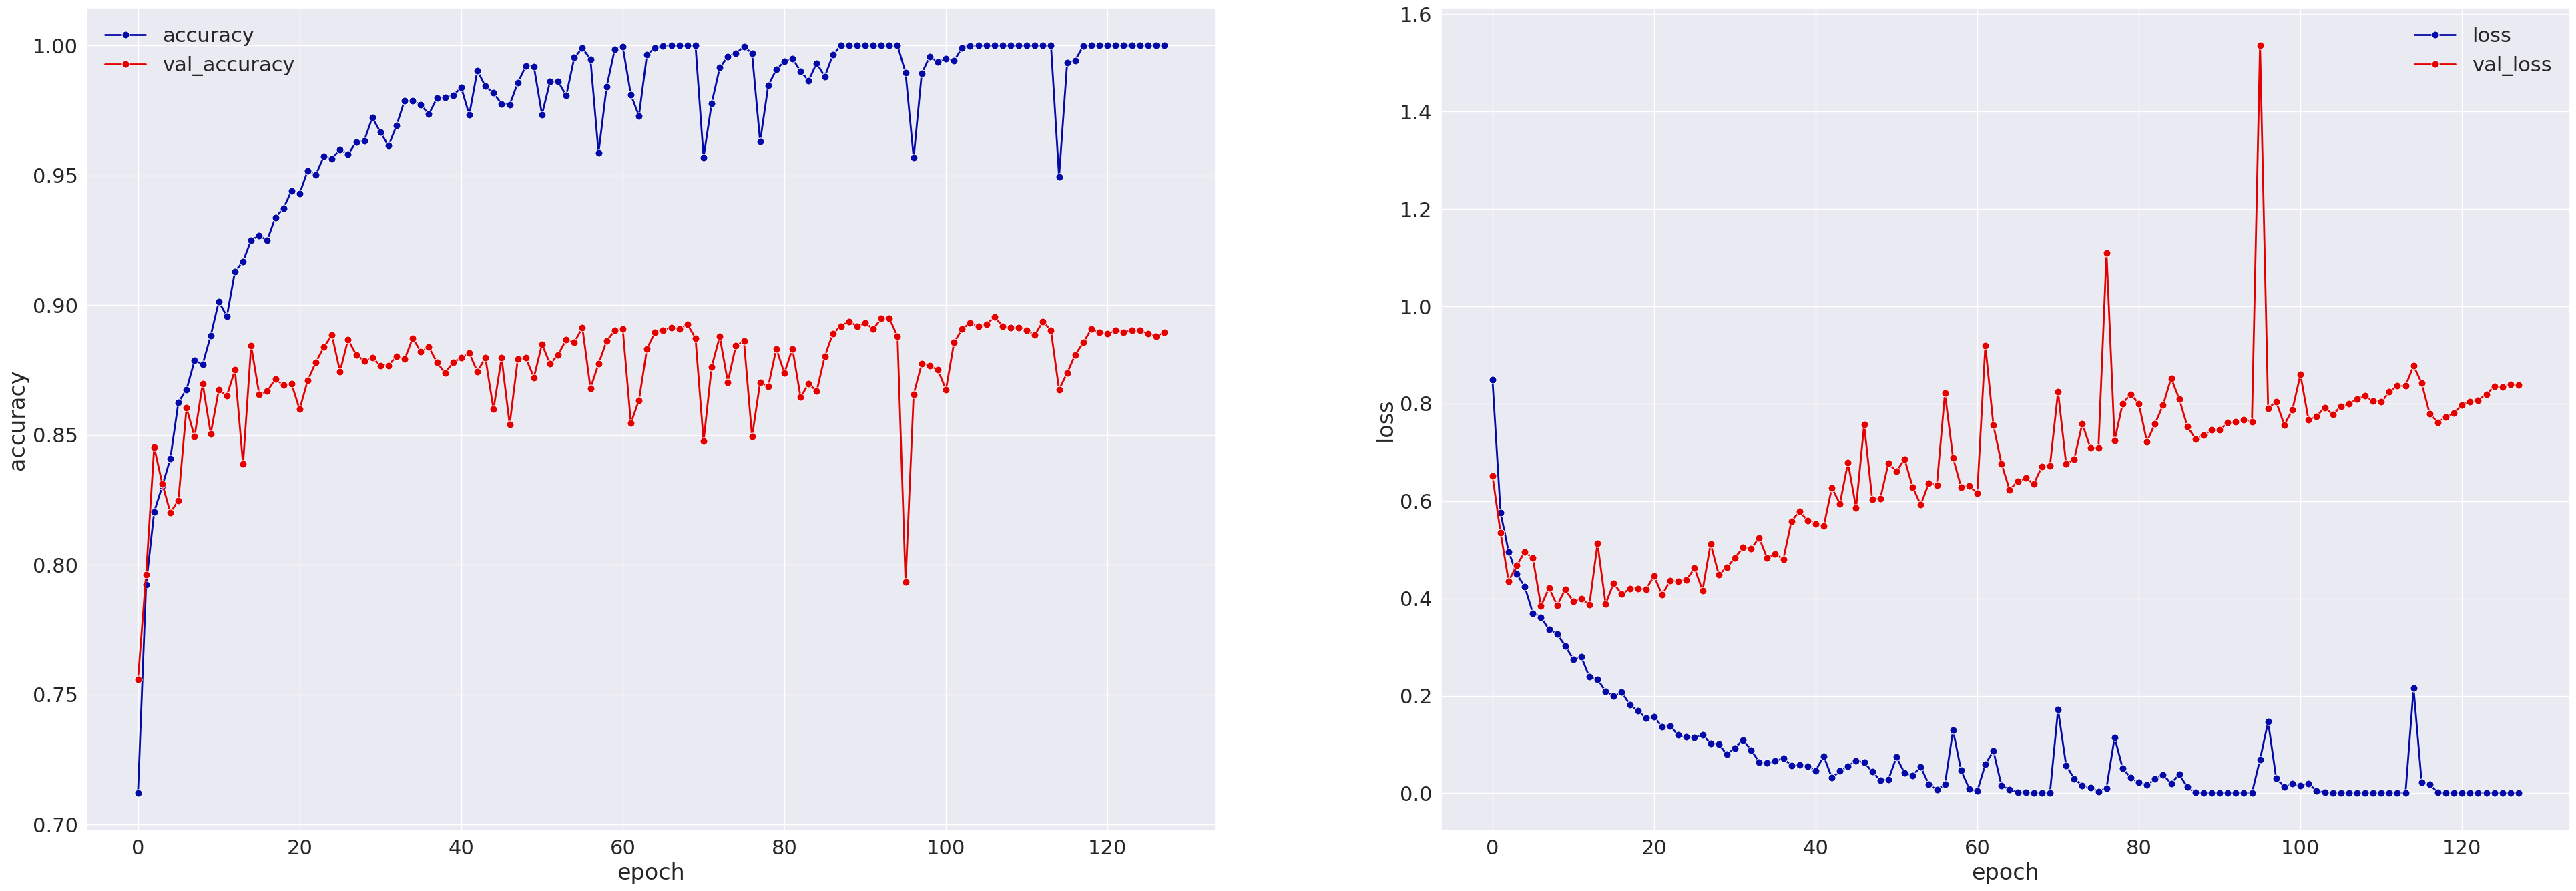

In [19]:
afficheHistoriqueEntrainement(history, palette)

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Sauvegarde du modèle </div></b>

In [20]:
one_hidden_layer_model.save(os.path.join(repertoireSauvegardes,'Keras-03-HistoriqueEntrainement.one_hidden_layer_history_batch_size_32.keras'))

In [21]:
sauvegarderModel(one_hidden_layer_model, 'one_hidden_layer_history_batch_size_32')

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Chargement du modèle </div></b>

In [22]:
model = tf.keras.models.load_model(os.path.join(repertoireSauvegardes,
                                   'Keras-03-HistoriqueEntrainement.one_hidden_layer_history_batch_size_32.keras'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2352)           │     5,534,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │        18,824 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,659,242 (63.55 MB)

 Trainable params: 5,553,080 (21.18 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,106,162 (42.37 MB)

In [23]:
model.fit(  apprentissage, 
            donnees["train_labels"].ravel(), 
            validation_data=(validation,donnees["val_labels"].ravel()), 
            epochs=2, 
            batch_size=batch_size, 
            verbose=2)

Epoch 1/2
374/374 - 2s - 5ms/step - accuracy: 0.9908 - loss: 0.0525 - val_accuracy: 0.7926 - val_loss: 1.8815
Epoch 2/2
374/374 - 0s - 1ms/step - accuracy: 0.9467 - loss: 0.1875 - val_accuracy: 0.8721 - val_loss: 0.8230


In [24]:
model.history.history

{'accuracy': [0.9908019304275513, 0.946651041507721],
 'loss': [0.05246502533555031, 0.18752433359622955],
 'val_accuracy': [0.792640209197998, 0.8720794320106506],
 'val_loss': [1.8814650774002075, 0.8229612112045288]}

In [25]:
h = pd.DataFrame( model.history.history)
h.reset_index(inplace=True)
h.rename(columns={'index':'epoch'},inplace=True)

In [26]:
h.epoch = h.epoch + 20

In [27]:
history = pd.concat([history,h],ignore_index=True)

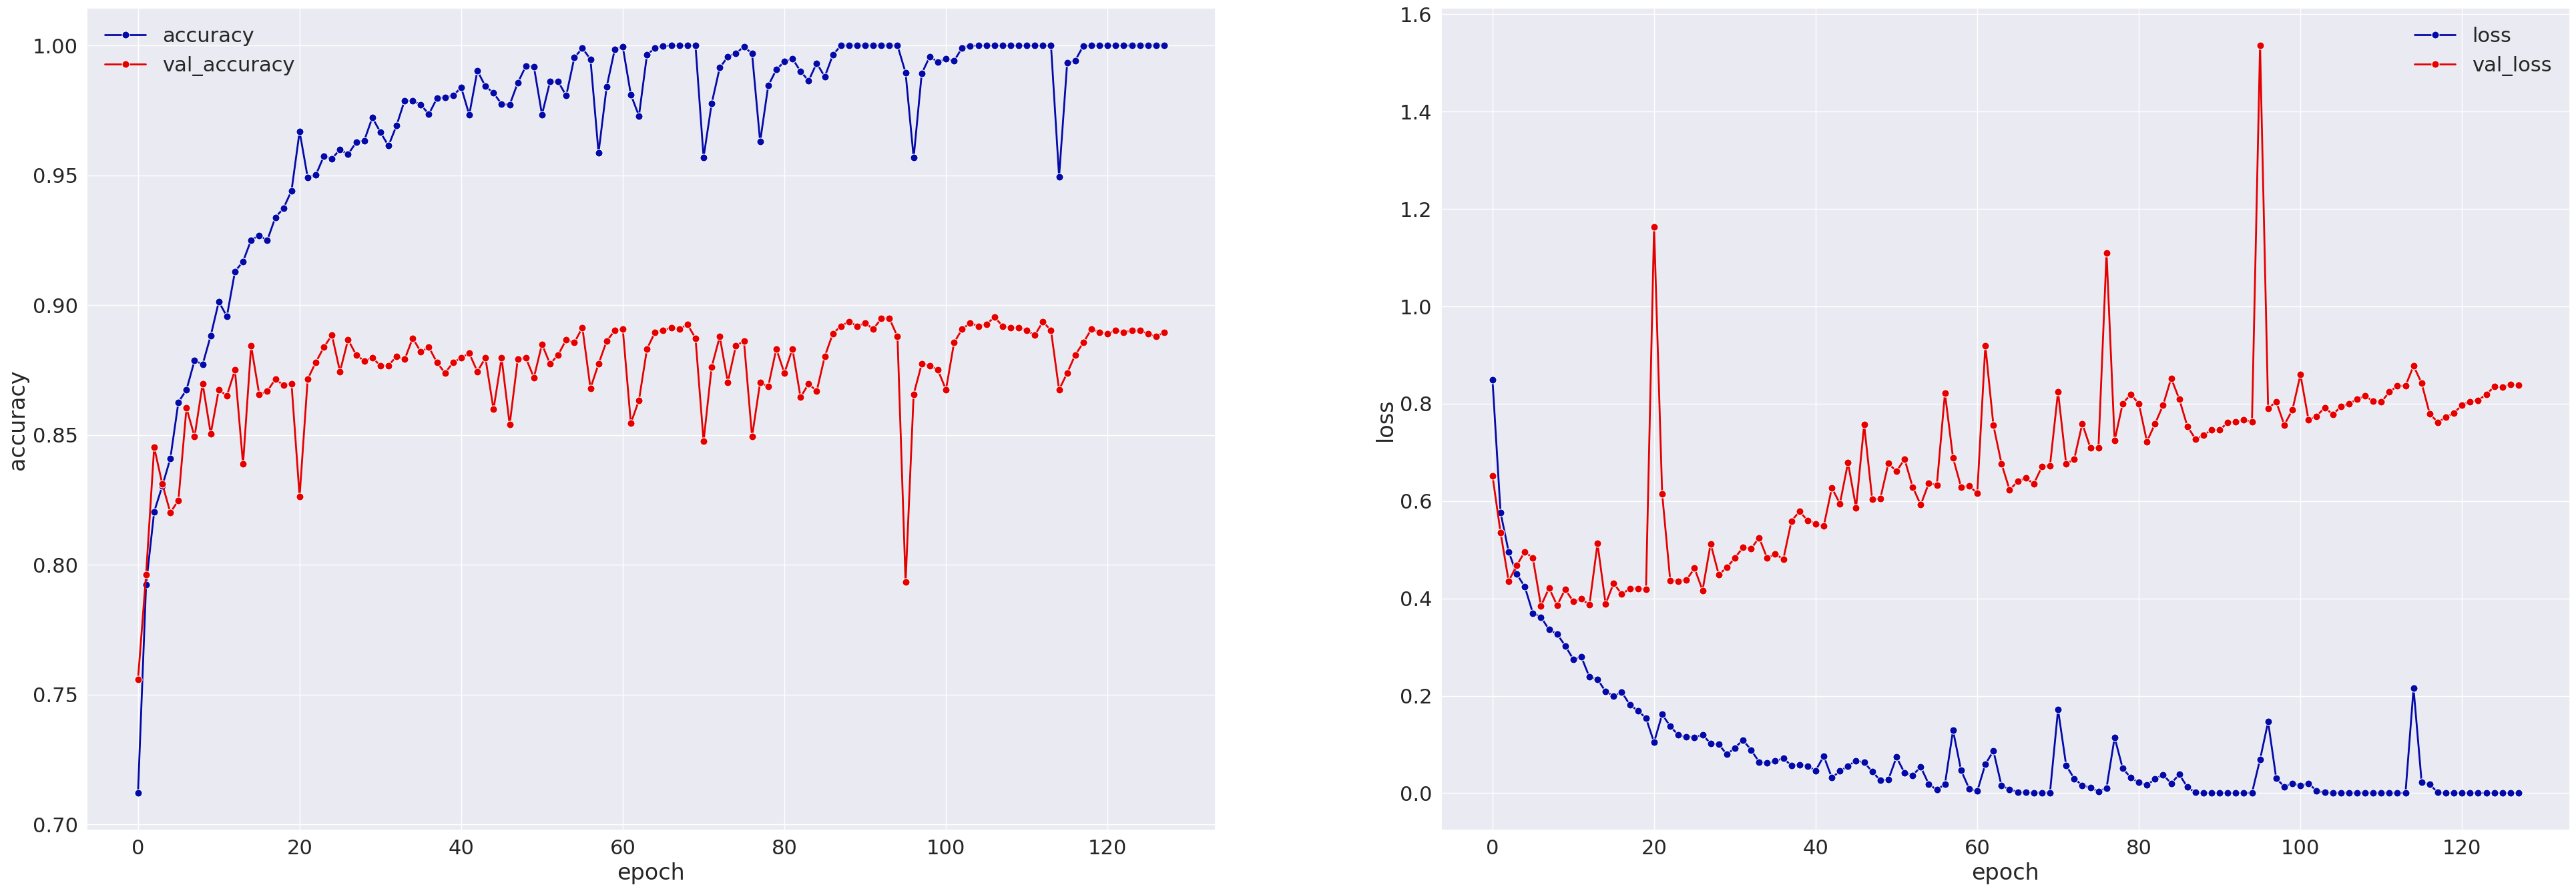

In [28]:
afficheHistoriqueEntrainement(history, palette)